### Введение
Загрузка датасетов. Вначале проанализируем датасеты за 2019 и 2020 год и построим модель предсказания факта просрочки на 2020 год по данным 2019 года. Сразу можно отметить, что только неполных данных бух баланса мало для постоения качественной модели. Как минимум, не хватает данных о сумме заключенных договоров с предприятием, проценты за просрочку, процентная ставка кредита, амортизация, наличие импорта за рубеж и доля импорта в выручке, уровень инфляции по годам, чтобы нормировать выручку по уровню инфляции.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from catboost import CatBoostClassifier, Pool, cv
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 150)

/Users/olgapalchul/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
path = '/Users/olgapalchul/Downloads/counterparty-analysis/'

df19 = pd.read_csv(path + 'agents2019.csv')
df20 = pd.read_csv(path + 'agents2020.csv')
df21 = pd.read_csv(path + 'agents2021.csv')

df19 = df19.drop('Unnamed: 0', axis=1)

Далее постоим модель для предсказания факта просрочки на 2020 год для поставщиков, с которыми сотрудничали в 2019 году (известен факт просрочки за 2019 год) и экономическими показателями за 2016 - 2019 гг (за 2020 год данные за неполное колич поставщиков). 

In [3]:
# в 2020 году создадим столбец, который содержит информацию о факте просрочки
df20['Факт просрочки20'] = df20['Макс. ПДЗ за 2020 год, дней'] > 0
df20_target = df20.copy()

# # удалим столбцы с факторами
for i in range(1, 61):
    df20_target = df20_target.drop([f"Факт. {i}"], axis=1)

# перевод сумм в млн
df20_target.loc[:, '2016, Нематериальные активы, RUB': '2019, Прибыль (убыток) от продажи, RUB'] = \
            (df20_target.loc[:, '2016, Нематериальные активы, RUB': '2019, Прибыль (убыток) от продажи, RUB'] / 1000000)

In [4]:
# из данных 2019 года возьмем информацию о просрочках 
df2019 = df19[['Наименование ДП', 'Макс. ПДЗ за 2019 год, дней',\
           'Сред. ПДЗ за 2019 год, дней', 'Кол-во просрочек свыше 5-ти дней за 2019 год, шт.',\
            'Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.', 'Кол-во раз ПДЗ за 2019 год, шт.']]

df19_target = df2019.merge(df20_target, on = 'Наименование ДП')

df19_target[['Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.', 'Общая сумма ПДЗ свыше 5-ти дней за 2020 год, руб.']] = \
        (df19_target[['Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.', 'Общая сумма ПДЗ свыше 5-ти дней за 2020 год, руб.']] / 1000000)

df19_target.head()

,Наименование ДП,"Макс. ПДЗ за 2019 год, дней","Сред. ПДЗ за 2019 год, дней","Кол-во просрочек свыше 5-ти дней за 2019 год, шт.","Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.","Кол-во раз ПДЗ за 2019 год, шт.",Итого,"Макс. ПДЗ за 2020 год, дней","Сред. ПДЗ за 2020 год, дней","Кол-во просрочек свыше 5-ти дней за 2020 год, шт.","Общая сумма ПДЗ свыше 5-ти дней за 2020 год, руб.","Кол-во раз ПДЗ за 2020 год, шт.","2016, Нематериальные активы, RUB","2017, Нематериальные активы, RUB","2018, Нематериальные активы, RUB","2019, Нематериальные активы, RUB","2016, Основные средства , RUB","2017, Основные средства , RUB","2018, Основные средства , RUB","2019, Основные средства , RUB","2016, Внеоборотные активы, RUB","2017, Внеоборотные активы, RUB","2018, Внеоборотные активы, RUB","2019, Внеоборотные активы, RUB","2016, Дебиторская задолженность, RUB","2017, Дебиторская задолженность, RUB","2018, Дебиторская задолженность, RUB","2019, Дебиторская задолженность, RUB","2016, Оборотные активы, RUB","2017, Оборотные активы, RUB","2018, Оборотные активы, RUB","2019, Оборотные активы, RUB","2016, Уставный капитал , RUB","2017, Уставный капитал , RUB","2018, Уставный капитал , RUB","2019, Уставный капитал , RUB","2016, Капитал и резервы, RUB","2017, Капитал и резервы, RUB","2018, Капитал и резервы, RUB","2019, Капитал и резервы, RUB","2016, Заёмные средства (долгосрочные), RUB","2017, Заёмные средства (долгосрочные), RUB","2018, Заёмные средства (долгосрочные), RUB","2019, Заёмные средства (долгосрочные), RUB","2016, Долгосрочные обязательства, RUB","2017, Долгосрочные обязательства, RUB","2018, Долгосрочные обязательства, RUB","2019, Долгосрочные обязательства, RUB","2016, Заёмные средства (краткосрочные), RUB","2017, Заёмные средства (краткосрочные), RUB","2018, Заёмные средства (краткосрочные), RUB","2019, Заёмные средства (краткосрочные), RUB","2016, Кредиторская задолженность, RUB","2017, Кредиторская задолженность, RUB","2018, Кредиторская задолженность, RUB","2019, Кредиторская задолженность, RUB","2016, Краткосрочные обязательства, RUB","2017, Краткосрочные обязательства, RUB","2018, Краткосрочные обязательства, RUB","2019, Краткосрочные обязательства, RUB","2016, Выручка, RUB","2017, Выручка, RUB","2018, Выручка, RUB","2019, Выручка, RUB","2016, Себестоимость продаж, RUB","2017, Себестоимость продаж, RUB","2018, Себестоимость продаж, RUB","2019, Себестоимость продаж, RUB","2016, Прибыль (убыток) до налогообложения , RUB","2017, Прибыль (убыток) до налогообложения , RUB","2018, Прибыль (убыток) до налогообложения , RUB","2019, Прибыль (убыток) до налогообложения , RUB","2016, Прибыль (убыток) от продажи, RUB","2017, Прибыль (убыток) от продажи, RUB","2018, Прибыль (убыток) от продажи, RUB","2019, Прибыль (убыток) от продажи, RUB",Факт просрочки20
0,0,0,0.0,0,0.000000,0,10.0,10,6.400000,4,2.229696,5,2.895541,6.245860,9.050955,9.885987,1889.724204,1803.724204,2145.239490,3606.102548,1928.685350,1880.842038,2440.077707,3737.611465,3583.765605,3683.358599,3475.461146,3692.142038,5159.380255,5897.326115,6077.447771,4981.792357,629.400000,629.400000,629.400000,629.400000,2673.019745,2971.017197,2289.273885,4865.035032,0.000000,0.000000,0.000000,0.000000,249.877707,258.973248,271.221019,276.483439,0.000000,0.000000,392.391720,0.000000,4080.056051,4452.921656,5476.906369,3478.978344,4165.168153,4548.177707,5957.030573,3577.885350,26676.980255,41626.929936,37039.522293,32347.554140,21568.144586,33354.425478,34383.128662,26734.812102,3179.696815,6167.666879,746.182803,3603.784076,3280.355414,6200.119745,871.619108,3658.633758,True
1,1,0,0.0,0,0.000000,0,20.0,4,4.000000,0,0.000000,1,0.000000,0.038854,0.034395,0.029299,144.810828,148.715287,152.642675,172.845860,145.678344,149.798726,153.892357,174.263694,55.847771,46.782166,156.347771,173.863694,148.915287,189.898726,291.463694,373.843312,1.345860,1.345860,1.345860,1.345860,272.664968,277.408280,310.658599,377.949682,0.000000,0.000000,0.000000,0.000000,3.108280,4.528025,5.033758,5.659236,9.74

In [5]:
df19_target = df19_target.drop(['2016, Нематериальные активы, RUB', '2017, Нематериальные активы, RUB',
                               '2016, Основные средства , RUB', '2017, Основные средства , RUB', 
                               '2016, Внеоборотные активы, RUB', '2017, Внеоборотные активы, RUB',
                                '2016, Дебиторская задолженность, RUB', '2017, Дебиторская задолженность, RUB',
                                '2016, Оборотные активы, RUB', '2017, Оборотные активы, RUB',
                                '2016, Уставный капитал , RUB', '2017, Уставный капитал , RUB',
                                '2016, Капитал и резервы, RUB', '2017, Капитал и резервы, RUB',
                                '2016, Заёмные средства (долгосрочные), RUB', '2017, Заёмные средства (долгосрочные), RUB',
                                '2016, Долгосрочные обязательства, RUB', '2017, Долгосрочные обязательства, RUB',
                                '2016, Заёмные средства (краткосрочные), RUB', '2017, Заёмные средства (краткосрочные), RUB',
                                '2016, Кредиторская задолженность, RUB', '2017, Кредиторская задолженность, RUB',
                                '2016, Краткосрочные обязательства, RUB', '2017, Краткосрочные обязательства, RUB',
                                '2016, Выручка, RUB', '2017, Выручка, RUB',
                                '2016, Себестоимость продаж, RUB', '2017, Себестоимость продаж, RUB',
                                '2016, Прибыль (убыток) до налогообложения , RUB', '2017, Прибыль (убыток) до налогообложения , RUB',
                                '2016, Прибыль (убыток) от продажи, RUB', '2017, Прибыль (убыток) от продажи, RUB'],axis=1)

### EDA


In [6]:
df19_target.describe()

,Наименование ДП,"Макс. ПДЗ за 2019 год, дней","Сред. ПДЗ за 2019 год, дней","Кол-во просрочек свыше 5-ти дней за 2019 год, шт.","Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.","Кол-во раз ПДЗ за 2019 год, шт.",Итого,"Макс. ПДЗ за 2020 год, дней","Сред. ПДЗ за 2020 год, дней","Кол-во просрочек свыше 5-ти дней за 2020 год, шт.","Общая сумма ПДЗ свыше 5-ти дней за 2020 год, руб.","Кол-во раз ПДЗ за 2020 год, шт.","2018, Нематериальные активы, RUB","2019, Нематериальные активы, RUB","2018, Основные средства , RUB","2019, Основные средства , RUB","2018, Внеоборотные активы, RUB","2019, Внеоборотные активы, RUB","2018, Дебиторская задолженность, RUB","2019, Дебиторская задолженность, RUB","2018, Оборотные активы, RUB","2019, Оборотные активы, RUB","2018, Уставный капитал , RUB","2019, Уставный капитал , RUB","2018, Капитал и резервы, RUB","2019, Капитал и резервы, RUB","2018, Заёмные средства (долгосрочные), RUB","2019, Заёмные средства (долгосрочные), RUB","2018, Долгосрочные обязательства, RUB","2019, Долгосрочные обязательства, RUB","2018, Заёмные средства (краткосрочные), RUB","2019, Заёмные средства (краткосрочные), RUB","2018, Кредиторская задолженность, RUB","2019, Кредиторская задолженность, RUB","2018, Краткосрочные обязательства, RUB","2019, Краткосрочные обязательства, RUB","2018, Выручка, RUB","2019, Выручка, RUB","2018, Себестоимость продаж, RUB","2019, Себестоимость продаж, RUB","2018, Прибыль (убыток) до налогообложения , RUB","2019, Прибыль (убыток) до налогообложения , RUB","2018, Прибыль (убыток) от продажи, RUB","2019, Прибыль (убыток) от продажи, RUB"
count,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,525.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,5.310000e+02,5.310000e+02,5.310000e+02,5.310000e+02,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,5.310000e+02,5.310000e+02,5.310000e+02,5.310000e+02,5.310000e+02,5.310000e+02,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000
mean,265.000000,27.743879,7.676839,6.491525,4.825706,17.951036,30.400000,26.924670,10.263054,9.167608,6.155193,22.875706,46.722021,58.773596,7.080918e+03,7.726455e+03,9.897002e+03,1.066235e+04,2148.776834,2535.494096,5009.867929,6290.577976,1284.199628,1404.963304,5.497492e+03,6.630589e+03,4.797155e+03,4.627470e+03,6.291704e+03,6.224511e+03,1011.658506,1243.342651,1933.671417,2649.282026,3117.675010,4097.829750,7481.677747,8580.840878,4890.154090,5672.857742,1312.543093,2561.710050,1988.514753,2262.094246
std,153.430766,111.782987,31.630274,21.681255,18.087129,45.883460,48.575431,69.438625,32.093828,31.945180,22.526939,54.068576,365.890610,461.713722,6.305067e+04,6.396236e+04,7.364587e+04,7.458432e+04,8231.941584,10174.010263,20734.588211,27924.000106,22029.265459,23081.286403,4.878870e+04,5.289535e+04,5.313151e+04,4.961984e+04,5.649485e+04,5.359923e+04,7461.466838,7422.115754,6777.213298,10548.544590,12791.014896,16660.130115,31505.343839,37220.188152,18526.152949,21138.212639,11933.985880,20929.752005,12711.999699,17279.940947
min,0.000000,0.000000,0.000000,0.000000,-2.978865,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.699205e+05,-9.694506e+03,-2.101911e-02,0.000000e+00,-1.357962e+00,0.000000e+00,0.000000,-0.401274,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-131630.508280,-14828.091083,-25208.489172,-5564.791720
25%,132.500000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.820701e+00,4.136943e+00,3.994904e+00,5.003822e+00,15.781529,20.404777,45.096815,61.784076,0.006369,0.006369,6.631847e+00,1.037803e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.044586e-02,0.000000,0.000000,23.329299,28.964331,29.674841,37.528025,168

In [7]:
print('Обшая сумма пдз свыше 5 дней за 2019 год', sum(df19_target['Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.']))
print('Обшая сумма пдз свыше 5 дней за 2019 год', sum(df19_target['Общая сумма ПДЗ свыше 5-ти дней за 2020 год, руб.']))

Обшая сумма пдз свыше 5 дней за 2019 год 2562.449736025479
Обшая сумма пдз свыше 5 дней за 2019 год 3268.4072909490437


Более половины предприятий не имеет нематериальных активов - компьютерных программ, ноу-хау и проч. Многие предприятия скрывают свои бух показатели - в такой ситуации возникает вопрос: на каком основании данному предприятию рассчитывали возможность поставки и на какую сумму? <br>
Среди всех контрагентов у Северстали есть как небольшие покупатели, так и довольно крупные предприятия. <br>
В 2019 году есть предприятия, которые имеют максимальную пдз более 2х лет.<br>
В 2020 году общая задолженность контрагентов выросла на 706 млн, также выросло среднее и медианное количество раз пдз в 2020 году, шт и среднее количество дней просрочки.

In [8]:
df19_target[df19_target['Макс. ПДЗ за 2019 год, дней'] > 365]

,Наименование ДП,"Макс. ПДЗ за 2019 год, дней","Сред. ПДЗ за 2019 год, дней","Кол-во просрочек свыше 5-ти дней за 2019 год, шт.","Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.","Кол-во раз ПДЗ за 2019 год, шт.",Итого,"Макс. ПДЗ за 2020 год, дней","Сред. ПДЗ за 2020 год, дней","Кол-во просрочек свыше 5-ти дней за 2020 год, шт.","Общая сумма ПДЗ свыше 5-ти дней за 2020 год, руб.","Кол-во раз ПДЗ за 2020 год, шт.","2018, Нематериальные активы, RUB","2019, Нематериальные активы, RUB","2018, Основные средства , RUB","2019, Основные средства , RUB","2018, Внеоборотные активы, RUB","2019, Внеоборотные активы, RUB","2018, Дебиторская задолженность, RUB","2019, Дебиторская задолженность, RUB","2018, Оборотные активы, RUB","2019, Оборотные активы, RUB","2018, Уставный капитал , RUB","2019, Уставный капитал , RUB","2018, Капитал и резервы, RUB","2019, Капитал и резервы, RUB","2018, Заёмные средства (долгосрочные), RUB","2019, Заёмные средства (долгосрочные), RUB","2018, Долгосрочные обязательства, RUB","2019, Долгосрочные обязательства, RUB","2018, Заёмные средства (краткосрочные), RUB","2019, Заёмные средства (краткосрочные), RUB","2018, Кредиторская задолженность, RUB","2019, Кредиторская задолженность, RUB","2018, Краткосрочные обязательства, RUB","2019, Краткосрочные обязательства, RUB","2018, Выручка, RUB","2019, Выручка, RUB","2018, Себестоимость продаж, RUB","2019, Себестоимость продаж, RUB","2018, Прибыль (убыток) до налогообложения , RUB","2019, Прибыль (убыток) до налогообложения , RUB","2018, Прибыль (убыток) от продажи, RUB","2019, Прибыль (убыток) от продажи, RUB",Факт просрочки20
28,28,747,113.700000,25,33.692931,50,10.0,363,92.777778,16,11.905181,27,1061.146497,1087.666242,88735.031847,105590.338217,208668.152866,213055.296815,80466.878981,69882.727389,159768.152866,129099.961783,3817.197452,3817.342038,214080.891720,190937.816561,53545.859873,67327.288535,60552.229299,74481.664331,13900.636943,19367.008280,75387.261146,55094.256051,93803.184713,76735.777707,314540.764331,268672.815924,211112.738854,201329.345223,86884.076433,61017.808280,72423.566879,38626.118471,True
57,57,560,75.206667,133,247.713804,150,240.0,0,0.000000,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False
84,84,842,20.842105,23,32.652849,57,30.0,18,5.111111,6,16.237424,18,7549.617834,8820.049045,238227.743949,227585.862420,471804.782166,476193.439490,39324.887261,136245.812102,171846.727389,340814.407006,100.792994,100.792994,124130.076433,222086.108917,362811.883439,336050.343312,402121.008917,362363.974522,75638.351592,114479.791083,32781.867516,108606.753503,117400.424204,232557.763057,387937.496178,559327.575159,151626.681529,185924.177707,134955.683439,398315.826115,209145.149045,342085.019108,True
126,126,820,148.230088,142,80.091398,226,60.0,457,144.375000,5,2.716416,16,0.000000,0.000000,47.682166,76.025478,56.140764,90.019745,2310.365605,4306.147771,3478.589172,6208.968153,59.896815,59.896815,-114.191720,824.477707,0.000000,0.000000,211.994904,178.137580,1374.124204,2018.303822,1822.947771,2462.019108,3436.926752,5296.372611,4619.331210,5826.626752,4870.169427,6323.973248,-421.779618,-816.774522,-392.109554,-687.242675,True
155,155,608,608.000000,2,1.289873,2,50.0,315,40.625000,1,0.240755,8,0.000000,0.000000,48.723567,55.078981,103.378344,100.512102,20.031847,79.936306,389.982803,341.516561,2.165605,2.165605,-385.149045,-344.526115,501.056688,597.565605,501.056688,597.565605,221.200000,30.238854,154.303185,157.627389,377.452866,188.989172,326.860510,267.711465,267.715924,238.536943,-95.558599,65.320382,19.542038,-10.823567,True
173,173,786,58.357143,3,10.858471,14,110.0,0,0.000000,0,0.000000,0,1.817197,80.212102,2032.882803,2188.124204,2048.734395,2314.445223,1269.530573,2720.884076,2415.645

В 2020 году мы видим, что у предприятий с высокой максимальной пдз за 2019 год уменьшилась пдз - 1. либо задолженность выплатили, 2. задолженность выплатитили.Также стоит отметить, что колонка с суммой оценок Итого за 2020 год не коррелирует с количеством раз пдз.  <br><br>
<h4>Построим графики пдз по годам - 2019, 2020, 2021</h4>

In [9]:
def return_day (data):
    
    ''' Функция возращает максимальный диапазон просрочки за 2021. 380 - условное обозначение просрочки дз более года''' 
    
    if (data['ПДЗ 1-30'] == 0) and (data['ПДЗ 31-90'] == 0) and (data['ПДЗ 91-365'] == 0) and (data['ПДЗ более 365'] == 0):
        return 0
    if (data['ПДЗ 1-30'] != 0) and (data['ПДЗ 31-90'] == 0) and (data['ПДЗ 91-365'] == 0) and (data['ПДЗ более 365'] == 0):
        return 30
    if (data['ПДЗ 1-30'] == 0) and (data['ПДЗ 31-90'] != 0) and (data['ПДЗ 91-365'] == 0) and (data['ПДЗ более 365'] == 0):
        return 90
    if (data['ПДЗ 1-30'] != 0) and (data['ПДЗ 31-90'] != 0) and (data['ПДЗ 91-365'] == 0) and (data['ПДЗ более 365'] == 0):
        return 90
    if (data['ПДЗ 1-30'] == 0) and (data['ПДЗ 31-90'] == 0) and (data['ПДЗ 91-365'] != 0) and (data['ПДЗ более 365'] == 0):
        return 365
    if (data['ПДЗ 1-30'] == 0) and (data['ПДЗ 31-90'] != 0) and (data['ПДЗ 91-365'] != 0) and (data['ПДЗ более 365'] == 0):
        return 365
    if (data['ПДЗ 1-30'] != 0) and (data['ПДЗ 31-90'] == 0) and (data['ПДЗ 91-365'] != 0) and (data['ПДЗ более 365'] == 0):
        return 365
    if (data['ПДЗ 1-30'] != 0) and (data['ПДЗ 31-90'] != 0) and (data['ПДЗ 91-365'] != 0) and (data['ПДЗ более 365'] == 0):
        return 365
    if (data['ПДЗ 1-30'] == 0) and (data['ПДЗ 31-90'] == 0) and (data['ПДЗ 91-365'] == 0) and (data['ПДЗ более 365'] != 0):
        return 380
    if (data['ПДЗ 1-30'] == 0) and (data['ПДЗ 31-90'] == 0) and (data['ПДЗ 91-365'] != 0) and (data['ПДЗ более 365'] != 0):
        return 380
    if (data['ПДЗ 1-30'] == 0) and (data['ПДЗ 31-90'] != 0) and (data['ПДЗ 91-365'] != 0) and (data['ПДЗ более 365'] != 0):
        return 380
    if (data['ПДЗ 1-30'] != 0) and (data['ПДЗ 31-90'] != 0) and (data['ПДЗ 91-365'] != 0) and (data['ПДЗ более 365'] != 0):
        return 380
    if (data['ПДЗ 1-30'] != 0) and (data['ПДЗ 31-90'] == 0) and (data['ПДЗ 91-365'] != 0) and (data['ПДЗ более 365'] != 0):
        return 380
    if (data['ПДЗ 1-30'] != 0) and (data['ПДЗ 31-90'] == 0) and (data['ПДЗ 91-365'] == 0) and (data['ПДЗ более 365'] != 0):
        return 380
    
df21['last_day21'] = df21.apply(return_day, axis=1)
df21.head()

,Unnamed: 0,Наименование ДП,"Макс. ПДЗ за 2019 год, дней","Сред. ПДЗ за 2019 год, дней","Кол-во просрочек свыше 5-ти дней за 2019 год, шт.","Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.","Кол-во раз ПДЗ за 2019 год, шт.","Макс. ПДЗ за 2020 год, дней","Сред. ПДЗ за 2020 год, дней","Кол-во просрочек свыше 5-ти дней за 2020 год, шт.","Общая сумма ПДЗ свыше 5-ти дней за 2020 год, руб.","Кол-во раз ПДЗ за 2020 год, шт.","Оценка потенциала контрагента 1, руб.","Оценка потенциала контрагента 2, руб.",Статус,"2016, Нематериальные активы, RUB","2017, Нематериальные активы, RUB","2018, Нематериальные активы, RUB","2019, Нематериальные активы, RUB","2020, Нематериальные активы, RUB","2016, Основные средства , RUB","2017, Основные средства , RUB","2018, Основные средства , RUB","2019, Основные средства , RUB","2020, Основные средства , RUB","2016, Внеоборотные активы, RUB","2017, Внеоборотные активы, RUB","2018, Внеоборотные активы, RUB","2019, Внеоборотные активы, RUB","2020, Внеоборотные активы, RUB","2016, Дебиторская задолженность, RUB","2017, Дебиторская задолженность, RUB","2018, Дебиторская задолженность, RUB","2019, Дебиторская задолженность, RUB","2020, Дебиторская задолженность, RUB","2016, Оборотные активы, RUB","2017, Оборотные активы, RUB","2018, Оборотные активы, RUB","2019, Оборотные активы, RUB","2020, Оборотные активы, RUB","2016, Уставный капитал , RUB","2017, Уставный капитал , RUB","2018, Уставный капитал , RUB","2019, Уставный капитал , RUB","2020, Уставный капитал , RUB","2016, Капитал и резервы, RUB","2017, Капитал и резервы, RUB","2018, Капитал и резервы, RUB","2019, Капитал и резервы, RUB","2020, Капитал и резервы, RUB","2016, Заёмные средства (долгосрочные), RUB","2017, Заёмные средства (долгосрочные), RUB","2018, Заёмные средства (долгосрочные), RUB","2019, Заёмные средства (долгосрочные), RUB","2020, Заёмные средства (долгосрочные), RUB","2016, Долгосрочные обязательства, RUB","2017, Долгосрочные обязательства, RUB","2018, Долгосрочные обязательства, RUB","2019, Долгосрочные обязательства, RUB","2020, Долгосрочные обязательства, RUB","2016, Заёмные средства (краткосрочные), RUB","2017, Заёмные средства (краткосрочные), RUB","2018, Заёмные средства (краткосрочные), RUB","2019, Заёмные средства (краткосрочные), RUB","2020, Заёмные средства (краткосрочные), RUB","2016, Кредиторская задолженность, RUB","2017, Кредиторская задолженность, RUB","2018, Кредиторская задолженность, RUB","2019, Кредиторская задолженность, RUB","2020, Кредиторская задолженность, RUB","2016, Краткосрочные обязательства, RUB","2017, Краткосрочные обязательства, RUB","2018, Краткосрочные обязательства, RUB","2019, Краткосрочные обязательства, RUB","2020, Краткосрочные обязательства, RUB","2016, Выручка, RUB","2017, Выручка, RUB","2018, Выручка, RUB","2019, Выручка, RUB","2020, Выручка, RUB","2016, Себестоимость продаж, RUB","2017, Себестоимость продаж, RUB","2018, Себестоимость продаж, RUB","2019, Себестоимость продаж, RUB","2020, Себестоимость продаж, RUB","2016, Прибыль (убыток) до налогообложения , RUB","2017, Прибыль (убыток) до налогообложения , RUB","2018, Прибыль (убыток) до налогообложения , RUB","2019, Прибыль (убыток) до налогообложения , RUB","2020, Прибыль (убыток) до налогообложения , RUB","2016, Прибыль (убыток) от продажи, RUB","2017, Прибыль (убыток) от продажи, RUB","2018, Прибыль (убыток) от продажи, RUB","2019, Прибыль (убыток) от продажи, RUB","2020, Прибыль (убыток) от продажи, RUB",Факт. 20,Факт. 21,Факт.32,Факт.31,Факт.23,Факт 24,Факт 27,Факт 33,Факт 28,Факт 29,Факт 30,Факт 40,Факт 41,Факт 42,Факт 46,Факт 48,Факт 49,Факт 50,Факт 51,Факт 54,Факт 55,Факт 56,Факт 57,Факт 58,Факт 59,Факт 60,Факт 37,Факт 39,Факт 1,Факт 2,Факт 3,Факт 7,Факт 12,Факт 14,Факт 15,Факт 16,Итого,ПДЗ 1-30,ПДЗ 31-90,ПДЗ 91-365,ПДЗ более 365,last_day21
0,0,0,0,0.0,0,0.000000,0,10,6.400000,4,2.229696e+06,5,3.715287e+06,3.715287e+06,Действующая,2.895541e+06,6.245860e+06,9.050955e+06,9.885987e+06,2.332484e+06,1.889724e+09,1.803724e+09,2.145239e+09,3

In [10]:
# df21.head()
df_target = df19_target.loc[:, 'Наименование ДП' : 'Кол-во раз ПДЗ за 2020 год, шт.']
# # в 2021 году создадим столбец, который содержит информацию о факте просрочки
df21['bool21'] = np.where(
            (df21['ПДЗ 1-30'] != 0) | (df21['ПДЗ 31-90'] != 0) | (df21['ПДЗ 91-365'] != 0) \
            | (df21['ПДЗ более 365'] != 0), True, False)
df2021 = df21[['Наименование ДП', 'last_day21','bool21']]
df_target = df_target.merge(df2021, how='left', on = 'Наименование ДП')

In [11]:
df_target = df_target.fillna(-1)
df_target['bool20'] = df_target['Кол-во раз ПДЗ за 2020 год, шт.'] > 0
df_target['bool19'] = df_target['Кол-во раз ПДЗ за 2019 год, шт.'] > 0
df_target.head()

,Наименование ДП,"Макс. ПДЗ за 2019 год, дней","Сред. ПДЗ за 2019 год, дней","Кол-во просрочек свыше 5-ти дней за 2019 год, шт.","Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.","Кол-во раз ПДЗ за 2019 год, шт.",Итого,"Макс. ПДЗ за 2020 год, дней","Сред. ПДЗ за 2020 год, дней","Кол-во просрочек свыше 5-ти дней за 2020 год, шт.","Общая сумма ПДЗ свыше 5-ти дней за 2020 год, руб.","Кол-во раз ПДЗ за 2020 год, шт.",last_day21,bool21,bool20,bool19
0,0,0,0.0,0,0.000000,0,10.0,10,6.400000,4,2.229696,5,380.0,True,True,False
1,1,0,0.0,0,0.000000,0,20.0,4,4.000000,0,0.000000,1,-1.0,-1,True,False
2,2,7,5.5,1,0.132825,2,40.0,6,5.333333,2,3.759242,3,380.0,True,True,True
3,3,0,0.0,0,0.000000,0,10.0,8,6.200000,3,7.152927,5,-1.0,-1,True,False
4,4,2,2.0,0,0.000000,2,20.0,1,1.000000,0,0.000000,2,0.0,False,True,True


In [12]:
def return_day20(data):
    
    ''' Функция возращает максимальный диапазон просрочки за 2020. 380 - условное обозначение просрочки дз более года'''
    
    if data['Макс. ПДЗ за 2020 год, дней'] == 0:
        return 0
    if 0 < data['Макс. ПДЗ за 2020 год, дней'] < 31:
        return 30
    if 30 < data['Макс. ПДЗ за 2020 год, дней'] < 91:
        return 90
    if 90 < data['Макс. ПДЗ за 2020 год, дней'] < 366:
        return 365
    if 366 < data['Макс. ПДЗ за 2020 год, дней'] < 10000:
        return 380
    
def return_day19(data):
    
    ''' Функция возращает максимальный диапазон просрочки за 2019. 380 - условное обозначение просрочки дз более года'''
    
    if data['Макс. ПДЗ за 2019 год, дней'] == 0:
        return 0
    if 0 < data['Макс. ПДЗ за 2019 год, дней'] < 31:
        return 30
    if 30 < data['Макс. ПДЗ за 2019 год, дней'] < 91:
        return 90
    if 90 < data['Макс. ПДЗ за 2019 год, дней'] < 366:
        return 365
    if 366 < data['Макс. ПДЗ за 2019 год, дней'] < 10000:
        return 380
    
df_target['last_day20'] = df_target.apply(return_day20, axis=1)
df_target['last_day19'] = df_target.apply(return_day19, axis=1)
df_target.head()

,Наименование ДП,"Макс. ПДЗ за 2019 год, дней","Сред. ПДЗ за 2019 год, дней","Кол-во просрочек свыше 5-ти дней за 2019 год, шт.","Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.","Кол-во раз ПДЗ за 2019 год, шт.",Итого,"Макс. ПДЗ за 2020 год, дней","Сред. ПДЗ за 2020 год, дней","Кол-во просрочек свыше 5-ти дней за 2020 год, шт.","Общая сумма ПДЗ свыше 5-ти дней за 2020 год, руб.","Кол-во раз ПДЗ за 2020 год, шт.",last_day21,bool21,bool20,bool19,last_day20,last_day19
0,0,0,0.0,0,0.000000,0,10.0,10,6.400000,4,2.229696,5,380.0,True,True,False,30,0
1,1,0,0.0,0,0.000000,0,20.0,4,4.000000,0,0.000000,1,-1.0,-1,True,False,30,0
2,2,7,5.5,1,0.132825,2,40.0,6,5.333333,2,3.759242,3,380.0,True,True,True,30,30
3,3,0,0.0,0,0.000000,0,10.0,8,6.200000,3,7.152927,5,-1.0,-1,True,False,30,0
4,4,2,2.0,0,0.000000,2,20.0,1,1.000000,0,0.000000,2,0.0,False,True,True,30,30


In [13]:
last_day19 = df_target.groupby('last_day19', as_index=False)\
                        .agg({'Наименование ДП': 'count'})
last_day19['per_cent'] = last_day19['Наименование ДП'] / sum(last_day19['Наименование ДП']) * 100

last_day20 = df_target.groupby('last_day20', as_index=False)\
                        .agg({'Наименование ДП': 'count'})
last_day20['per_cent'] = last_day20['Наименование ДП'] / sum(last_day20['Наименование ДП']) * 100

last_day21 = df_target.groupby('last_day21', as_index=False)\
                        .agg({'Наименование ДП': 'count'})
last_day21 = last_day21[1:]
last_day21['per_cent'] = last_day21['Наименование ДП'] / sum(last_day21['Наименование ДП']) * 100

In [14]:
# last_day19

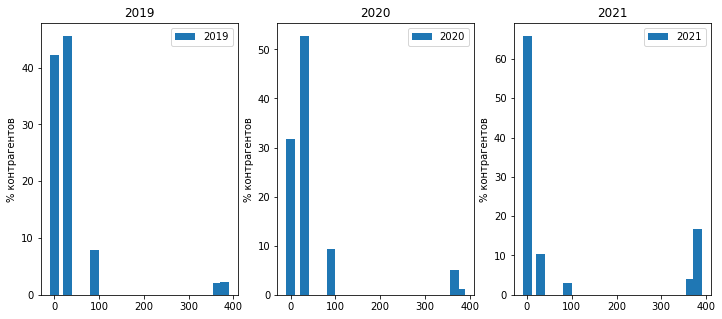

In [15]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(12,5))

ax[0].set_title('2019')
ax[0].bar('last_day19', 'per_cent', data=last_day19, width=20, label='2019')
ax[0].set_ylabel('% контрагентов')
ax[0].legend()

ax[1].set_title('2020')
ax[1].bar('last_day20', 'per_cent', data=last_day20, width=20, label='2020')
ax[1].set_ylabel('% контрагентов')
ax[1].legend()

ax[2].set_title('2021')
ax[2].bar('last_day21', 'per_cent', data=last_day21, width=20, label='2021')
ax[2].set_ylabel('% контрагентов')
ax[2].legend()
plt.show()

В 2020 году мы видим рост просрочек до 30 дней и уменьшение числа погашения дз в срок. Также уменьшилось число просрочек свыше года - возможно, их списали или выплатили. Вполне вероятно, что на увеличение доли просрочек повлияла ситуация с ковид-19 и локдауном в России, а также в Европе, что привело к нарушению отлаженных процессов производства. В 2021 году у нас уменьшилось число контрагентов (возможно, влияние 2020 года и уход некоторых контрагентов с рынка). В 2021 году более 60% всех контрагентов платит в срок, резко увеличилась доля просрочек свыше года (опять же, возможное влияние 2020). <br>
Так как у нас есть только данные бух учета, без влияния внешних факторов - постоить качесвтвенную модель с высокой точностью (более 90%) будет достаточно трудно. 

<h4>Построение модели предсказания CatBoost</h4>
<h5>Генерирование новых признаков на основе данных бух баланса</h5>

In [16]:
years = ['2018, ', '2019, ']

def generator_18_19(data):
    """функция для генерации основных экономических показателей предприятий за два года на основании данных бухгалтерского баланса.
        Принимает исходные данные бух учета, возвращает новые столбцы с признаками"""
    for year in years:
    # графа баланса оборотные активы   
        data[f"{year}current_assets"] = data[f"{year}Нематериальные активы, RUB"] \
                                        + data[f"{year}Основные средства , RUB"] \
                                        + data[f"{year}Внеоборотные активы, RUB"] 
    # графа баланса внеоборотные активы   
        data[f"{year}non_current_assets"] =  + data[f"{year}Дебиторская задолженность, RUB"]\
                                                + data[f"{year}Оборотные активы, RUB"]
    # графа баланса капитал и резервы   
        data[f"{year}capital"] = data[f"{year}Уставный капитал , RUB"] + data[f"{year}Капитал и резервы, RUB"]
    # графа баланса долгосрочные обязательства
        data[f"{year}long_term_liabil"] = data[f"{year}Заёмные средства (долгосрочные), RUB"] \
                                            + data[f"{year}Долгосрочные обязательства, RUB"]
    # графа баланса краткосрочные обязательства   
        data[f"{year}short_term_liabil"] = data[f"{year}Заёмные средства (краткосрочные), RUB"]\
                                            + data[f"{year}Кредиторская задолженность, RUB"]\
                                            + data[f"{year}Краткосрочные обязательства, RUB"]
    # доля дебиторской задолжности в активах   
        data[f"{year}dept_activ"] = data[f"{year}Дебиторская задолженность, RUB"] / (data[f"{year}current_assets"] + data[f"{year}non_current_assets"])
    # доля кредиторской задолжности в пассивах   
        data[f"{year}credit_passiv"] = data[f"{year}Кредиторская задолженность, RUB"] / (data[f"{year}long_term_liabil"] + data[f"{year}short_term_liabil"] + data[f"{year}capital"])
    # соотношение коэффициентов дебиторской и кредторской задолжностей 
        data[f"{year}dept_credit"] = data[f"{year}dept_activ"] / data[f"{year}credit_passiv"]
    # рабочий капитал - размер капитала, который имеется у организации для финансирования его текущей деятельности
        data[f"{year}work_capit"] = data[f"{year}Оборотные активы, RUB"] - data[f"{year}Краткосрочные обязательства, RUB"]
    # рентабельность продаж
        data[f"{year}gross_profit"] = data[f"{year}Прибыль (убыток) от продажи, RUB"] / data[f"{year}Выручка, RUB"]
    # доля заемных средств в пассивах   
        data[f"{year}part_long_bor"] = data[f"{year}Заёмные средства (долгосрочные), RUB"] / (data[f"{year}long_term_liabil"] + data[f"{year}short_term_liabil"] + data[f"{year}capital"])
    # доля долгосрочных обязательств в пассивах
        data[f"{year}part_long_obligat"] = data[f"{year}Долгосрочные обязательства, RUB"] / (data[f"{year}long_term_liabil"] + data[f"{year}short_term_liabil"] + data[f"{year}capital"])
    # доля краткосрочных средств в пассивых
        data[f"{year}part_short_bor"] = data[f"{year}Заёмные средства (краткосрочные), RUB"] / (data[f"{year}long_term_liabil"] + data[f"{year}short_term_liabil"] + data[f"{year}capital"])
    # соотношение активов и пассивов
        data[f"{year}activ_passiv"] = (data[f"{year}long_term_liabil"] + data[f"{year}short_term_liabil"]) / (data[f"{year}long_term_liabil"] + data[f"{year}short_term_liabil"] + data[f"{year}capital"])
    # доля кратносрочных обязательств в пассивах
        data[f"{year}current_assets"] = data[f"{year}non_current_assets"] / (data[f"{year}long_term_liabil"] + data[f"{year}short_term_liabil"] + data[f"{year}capital"])
    # рентабельность продукции
        data[f"{year}profit_product"] = data[f"{year}Прибыль (убыток) от продажи, RUB"] / data[f"{year}Себестоимость продаж, RUB"]    
    # рентабельность выручки
        data[f"{year}profit_revenue"] = data[f"{year}Выручка, RUB"] / data[f"{year}Себестоимость продаж, RUB"]
    # рентабельность активов
        data[f"{year}profit_assets"] = data[f"{year}Прибыль (убыток) от продажи, RUB"] / (data[f"{year}current_assets"] + data[f"{year}non_current_assets"])  
    # рентабельность текущих активов
        data[f"{year}profit_cur_assets"] = data[f"{year}Прибыль (убыток) от продажи, RUB"] / data[f"{year}current_assets"]
    # рентабельность совупного капитала
        data[f"{year}profit_total_capital"] = data[f"{year}Прибыль (убыток) от продажи, RUB"] / data[f"{year}capital"]
    # коэффициент финансовой зависимости
        data[f"{year}fin_depen"] = (data[f"{year}Заёмные средства (долгосрочные), RUB"] + data[f"{year}Заёмные средства (краткосрочные), RUB"]) / data[f"{year}capital"]
    # показатель ликвидности
        data[f"{year}liquidity"] = data[f"{year}Дебиторская задолженность, RUB"] / data[f"{year}Краткосрочные обязательства, RUB"]
    # отношение прибыли и пассивов
        data[f"{year}profit_rev_pas"] = data[f"{year}Прибыль (убыток) от продажи, RUB"] / (data[f"{year}long_term_liabil"] + data[f"{year}short_term_liabil"] + data[f"{year}capital"])
    return data
        
def generator_feat18_19(data):
    
    """ функция генерации экономических показателей. Возвращает датасет с новыми столбцами"""
    
    # отношение прибыли к активам за период
    data[f"{years[1]}profit_rev_activ"] = data[f"{years[1]}Прибыль (убыток) от продажи, RUB"] / \
            (((data[f"{years[1]}current_assets"] + data[f"{years[1]}non_current_assets"]) + \
            (data[f"{years[0]}current_assets"] + data[f"{years[0]}non_current_assets"])) / 2)
    # отношение прибыли к пассивам за период
    data[f"{years[1]}profit_rev_activ"] = data[f"{years[1]}Прибыль (убыток) от продажи, RUB"] / \
            (((data[f"{years[1]}long_term_liabil"] + data[f"{years[1]}short_term_liabil"]) + \
            (data[f"{years[0]}long_term_liabil"] + data[f"{years[0]}short_term_liabil"])) / 2)
    # отношение прибыли к капиталу за период   
    data[f"{years[1]}profit_rev_capit"] = data[f"{years[1]}Прибыль (убыток) от продажи, RUB"] / \
            ((data[f"{years[1]}capital"] + data[f"{years[0]}capital"]) / 2)
    # отношение прибыли к оборотным активам за период   
    data[f"{years[1]}profit_rev_cur_activ"] = data[f"{years[1]}Прибыль (убыток) от продажи, RUB"] / \
            ((data[f"{years[1]}Оборотные активы, RUB"] + data[f"{years[0]}Оборотные активы, RUB"]) / 2)
    # отношение прибыли к кредиторской задолженности за период
    data[f"{years[1]}profit_rev_cred_activ"] = data[f"{years[1]}Прибыль (убыток) от продажи, RUB"] / \
            ((data[f"{years[1]}Кредиторская задолженность, RUB"] + data[f"{years[0]}Кредиторская задолженность, RUB"]) / 2)
    # отношение прибыли к себестоимости продаж. за период
    data[f"{years[1]}profit_capit"] = data[f"{years[1]}Прибыль (убыток) от продажи, RUB"] / \
            ((data[f"{years[1]}Себестоимость продаж, RUB"] +data[f"{years[0]}Себестоимость продаж, RUB"]) / 2)  
    # признаки в динамике
    data[f"{years[1]}dyn_debt"] = data[f"{years[1]}Дебиторская задолженность, RUB"] / data[f"{years[0]}Дебиторская задолженность, RUB"]
    data[f"{years[1]}dyn_cur_act"] = data[f"{years[1]}Оборотные активы, RUB"] / data[f"{years[0]}Оборотные активы, RUB"]
    data[f"{years[1]}dyn_long_term"] = data[f"{years[1]}Заёмные средства (долгосрочные), RUB"] / data[f"{years[0]}Заёмные средства (долгосрочные), RUB"]
    data[f"{years[1]}dyn_long_term1"] = data[f"{years[1]}Долгосрочные обязательства, RUB"] / data[f"{years[0]}Долгосрочные обязательства, RUB"]
    data[f"{years[1]}dyn_short_term"] = data[f"{years[1]}Заёмные средства (краткосрочные), RUB"] / data[f"{years[0]}Заёмные средства (краткосрочные), RUB"]
    data[f"{years[1]}dyn_credit"] = data[f"{years[1]}Кредиторская задолженность, RUB"] / data[f"{years[0]}Кредиторская задолженность, RUB"]
    data[f"{years[1]}dyn_short_term1"] = data[f"{years[1]}Краткосрочные обязательства, RUB"] / data[f"{years[0]}Краткосрочные обязательства, RUB"]
    data[f"{years[1]}dyn_prof"] = data[f"{years[1]}Выручка, RUB"] / data[f"{years[0]}Выручка, RUB"]
    data[f"{years[1]}dyn_cost_price"] = data[f"{years[1]}Себестоимость продаж, RUB"] / data[f"{years[0]}Себестоимость продаж, RUB"]
    data[f"{years[1]}dyn_prof1"] = data[f"{years[1]}Прибыль (убыток) от продажи, RUB"] / data[f"{years[0]}Прибыль (убыток) от продажи, RUB"]
    
    return data

In [17]:
df19_target = generator_18_19(df19_target)

df19_target = generator_feat18_19(df19_target)

In [38]:
df19_target1 = df19_target.drop([
    #'Кол-во просрочек свыше 5-ти дней за 2019 год, шт.',\
                                'Макс. ПДЗ за 2019 год, дней', \
                                'Сред. ПДЗ за 2019 год, дней',\
                                 'Кол-во раз ПДЗ за 2019 год, шт.',\
                                 'Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.',\
                                 'Кол-во раз ПДЗ за 2019 год, шт.',\
                                'Макс. ПДЗ за 2020 год, дней',\
                                'Сред. ПДЗ за 2020 год, дней',\
                                 'Кол-во раз ПДЗ за 2020 год, шт.',
                                'Кол-во просрочек свыше 5-ти дней за 2020 год, шт.',\
                                'Общая сумма ПДЗ свыше 5-ти дней за 2020 год, руб.'], axis=1)
                                # 
df19_target1.shape[1]
#Факт просрочки20

95

Итого в обучающей выборке будет участвовать 93 признака.

### Обучение модели 
Модель обучения настроена предсказывать факт дебеторской (True/False) на основании данных бух учета за три года. Основные признаки качества модели - AUC и Accuracy (точность). 

In [39]:
X = np.array(df19_target1.drop(['Факт просрочки20', 'Наименование ДП'], axis=1))

Y = df19_target1['Факт просрочки20']

# X = PolynomialFeatures(degree=2).fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

best_auc_percent = 0
best_model_parameters = None
best_model = None
for depth in [1, 3, 5, 7]:
    for iterations in [100]:
        for learning_rate in [0.003, 0.01, 0.03, 0.1, 0.3]:
            for l2_leaf_reg in [0.003, 0.01, 0.03, 0.1, 0.3]:
                for border_count in [4, 8, 16, 32, 64, 128]:
                    model = CatBoostClassifier(
                        depth=depth, iterations=iterations, learning_rate=learning_rate,
                        l2_leaf_reg =l2_leaf_reg, border_count=border_count,
                        use_best_model=True, verbose=False, eval_metric = 'AUC')
                    model.fit(x_train, y_train, eval_set=(x_test, y_test))

                    predictions = model.predict(x_test)
                    predictions = [True if (prediction == 'True') else False for prediction in predictions]
                    
                    y_test_ = np.array(y_test)
                    predict_proba = model.predict_proba(x_test)
                    auc = metrics.roc_auc_score(y_test_, predict_proba[:, 1])
                    
                    
                    auc_percent = auc * 100.0
                    current_model_parameters = 'depth={}, iterations={}, learning_rate={}, l2_leaf_reg={}, border_count={}'\
                        .format(depth, iterations, learning_rate, l2_leaf_reg, border_count)
                    if (best_auc_percent < auc_percent):
                        best_auc_percent = auc_percent
                        best_model_parameters = current_model_parameters
                        best_model = model
                        
                        print("AUC: %.2f%%" % auc_percent, current_model_parameters)
                        print("Accuracy:", (accuracy_score(y_test, predictions)) * 100)
                        
                    
print("Best auc: %.2f%%" % best_auc_percent, best_model_parameters)

AUC: 61.40% depth=1, iterations=100, learning_rate=0.003, l2_leaf_reg=0.003, border_count=4
Accuracy: 74.76635514018692
AUC: 63.87% depth=1, iterations=100, learning_rate=0.003, l2_leaf_reg=0.003, border_count=8
Accuracy: 75.70093457943925
AUC: 65.43% depth=1, iterations=100, learning_rate=0.003, l2_leaf_reg=0.03, border_count=4
Accuracy: 75.70093457943925
AUC: 65.72% depth=7, iterations=100, learning_rate=0.1, l2_leaf_reg=0.3, border_count=32
Accuracy: 74.76635514018692
Best auc: 65.72% depth=7, iterations=100, learning_rate=0.1, l2_leaf_reg=0.3, border_count=32


<h5>Лучшая полученная Accuracy - 74,77%, лучший AUC - 65,72% - модель дает достаточно хороший результат на таком наборе данных

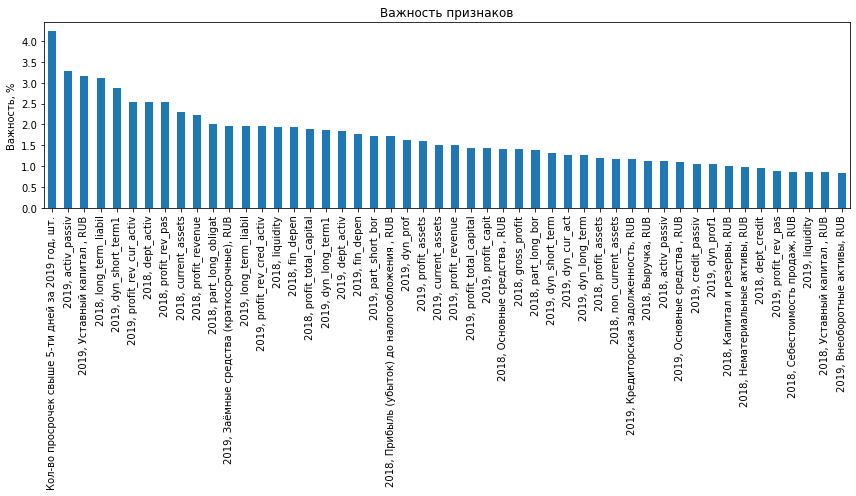

In [40]:
df_imp = pd.Series(model.get_feature_importance(),
                   df19_target1.drop(['Факт просрочки20', 'Наименование ДП'], axis=1).columns).sort_values(ascending=False).head(50)

fig, ax = plt.subplots(figsize=(12,7))
df_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

в топе важных для модели признаков - общее кол-во просрочек свыше 5 дней в 2019,<br>
отношение активов к пассивам за 2019 г<br>
уставной капитал за 2019<br>
долгосрочные обязательства за 2018<br>
динамика краткосрочных обязательств 2018-2019 гг<br>
отношение прибыли к средним оборотным активам за 2018-2019 гг<br>
отношение дебиторской задолженности к активам в 2018 г<br>
отношение прибыли и пассивов в 2018 г<br>
рентабельность выручки 2018 г<br>
оборотные активы 2019 г<br>
Модель для обучения использует в большинстве относительные признаки и динамические признаки

In [41]:
df19_target2 = df19_target.drop(['Кол-во просрочек свыше 5-ти дней за 2019 год, шт.',\
                                'Макс. ПДЗ за 2019 год, дней', \
                                'Сред. ПДЗ за 2019 год, дней',\
                                 'Кол-во раз ПДЗ за 2019 год, шт.',\
                                 'Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.',\
                                 'Кол-во раз ПДЗ за 2019 год, шт.',\
                                'Макс. ПДЗ за 2020 год, дней',\
                                'Сред. ПДЗ за 2020 год, дней',\
                                 'Кол-во раз ПДЗ за 2020 год, шт.',
                                'Кол-во просрочек свыше 5-ти дней за 2020 год, шт.',\
                                'Общая сумма ПДЗ свыше 5-ти дней за 2020 год, руб.'], axis=1)

In [42]:
X = np.array(df19_target2.drop(['Факт просрочки20', 'Наименование ДП'], axis=1))

Y = df19_target2['Факт просрочки20']

# X = PolynomialFeatures(degree=2).fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

best_auc_percent = 0
best_model_parameters = None
best_model = None
for depth in [1, 3, 5, 7]:
    for iterations in [100]:
        for learning_rate in [0.003, 0.01, 0.03, 0.1, 0.3]:
            for l2_leaf_reg in [0.003, 0.01, 0.03, 0.1, 0.3]:
                for border_count in [4, 8, 16, 32, 64, 128]:
                    model = CatBoostClassifier(
                        depth=depth, iterations=iterations, learning_rate=learning_rate,
                        l2_leaf_reg =l2_leaf_reg, border_count=border_count,
                        use_best_model=True, verbose=False, eval_metric = 'AUC')
                    model.fit(x_train, y_train, eval_set=(x_test, y_test))

                    predictions = model.predict(x_test)
                    predictions = [True if (prediction == 'True') else False for prediction in predictions]
                    
                    y_test_ = np.array(y_test)
                    predict_proba = model.predict_proba(x_test)
                    auc = metrics.roc_auc_score(y_test_, predict_proba[:, 1])
                    
                    
                    auc_percent = auc * 100.0
                    current_model_parameters = 'depth={}, iterations={}, learning_rate={}, l2_leaf_reg={}, border_count={}'\
                        .format(depth, iterations, learning_rate, l2_leaf_reg, border_count)
                    if (best_auc_percent < auc_percent):
                        best_auc_percent = auc_percent
                        best_model_parameters = current_model_parameters
                        best_model = model
                        
                        print("AUC: %.2f%%" % auc_percent, current_model_parameters)
                        print("Accuracy:", (accuracy_score(y_test, predictions)) * 100)
                        
                    
print("Best auc: %.2f%%" % best_auc_percent, best_model_parameters)

AUC: 65.19% depth=1, iterations=100, learning_rate=0.003, l2_leaf_reg=0.003, border_count=4
Accuracy: 75.70093457943925
AUC: 65.53% depth=3, iterations=100, learning_rate=0.003, l2_leaf_reg=0.003, border_count=16
Accuracy: 74.76635514018692
AUC: 67.33% depth=3, iterations=100, learning_rate=0.003, l2_leaf_reg=0.01, border_count=16
Accuracy: 74.76635514018692
AUC: 69.52% depth=3, iterations=100, learning_rate=0.003, l2_leaf_reg=0.3, border_count=16
Accuracy: 74.76635514018692
Best auc: 69.52% depth=3, iterations=100, learning_rate=0.003, l2_leaf_reg=0.3, border_count=16


<h5>Лучшая полученная Accuracy - 74,77%, лучший AUC - 69,52% - лучший AUC, в сравнении с предыдущей моделью

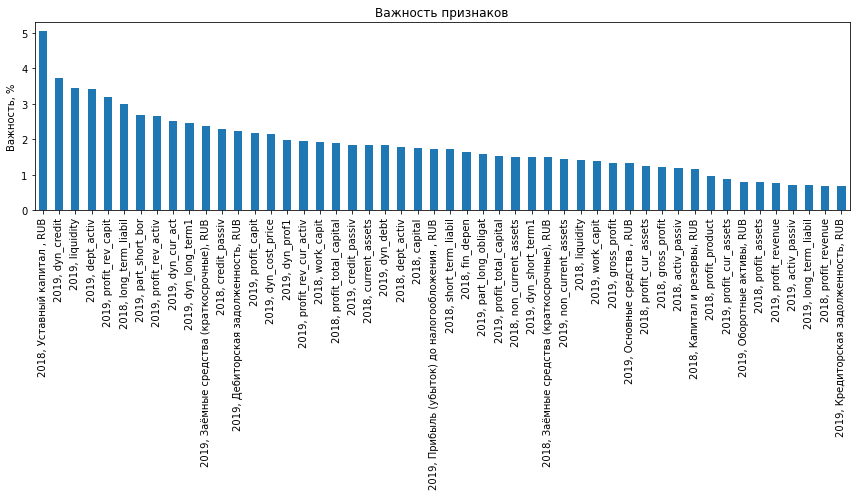

In [43]:
df_imp = pd.Series(model.get_feature_importance(),
                   df19_target2.drop(['Факт просрочки20', 'Наименование ДП'], axis=1).columns).sort_values(ascending=False).head(50)

fig, ax = plt.subplots(figsize=(12,7))
df_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

Топ-10 признаков:
уставной капитал 2018 г<br>
отношение кредитных среств 2019 г к 2018 г <br>
ликвидность 2019<br>
доля дебеторской задолженности в активах<br>
отношение прибыли к капиталу за 2019 г<br>
сумма долгосрочных заемных средств 2018 г<br>
доля краткосрочных средств в пассивах 2019<br>
отношение прибыли к активам за период 2019<br>
динамика оборотных активов 2018-2019<br>
динамика долгосрочных обязательств 2018-2019<br>

### Заключение <br>
Как было отмечено выше, одних данных бухгалтерского учета недостаточно для построения точной модели обучения. На основании предаставленных данных бух. учета были сгенерированы относительные и динамические признаки, на основании которых обучалась модель. Самый высокий результат обучения - Accuracy - 74,77%, лучший AUC - 69,52% - получен на модели предсказывания факта просрочки на 2020 год на основании данных 2018-2019 гг. Для модели наиболее важны следующие признаки: дебеторская задолженность, долго- и краткосрочные обязательства, кредитные средства и прибыль. 